# Posthoc Inference on Contrasts

In this notebook, we provide examples of how to run posthoc inference to infer on contrasts in the linear model.

## Set Up

#### Import the required python packages.

In [1]:
import numpy as np
import numpy.matlib as npm
import matplotlib.pyplot as plt 

import sanssouci as ss

import pyrft as pr

#### Initialize the example

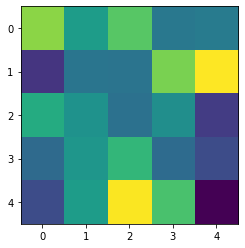

In [2]:
# Set the dimension of the example and the number of subjects
Dim = (50,50); N = 30; m = np.prod(Dim)

# Generate the category vector and obtain the corresponding design matrix
from sklearn.utils import check_random_state
rng = check_random_state(101)
categ = rng.choice(3, N, replace = True)
X = pr.groupX(categ); 

# Specify the contrast matrix (here 2 contrasts are chosen)
C = np.array([[1,-1,0],[0,1,-1]]); 

# Calulate the number contrasts
L = C.shape[0]

# Calculate the number of p-values generated (L for each voxels)
npvals = m*L

# Generate a white noise field
lat_data = pr.wfield(Dim,N)

# Generate a stationary random field with given FWHM
# FWHM = 4; lat_data = pr.statnoise(Dim, N, FWHM)

# Plot a sample realization of the noise
plt.imshow(lat_data.field[:,:,1])  

### Add signal to the field

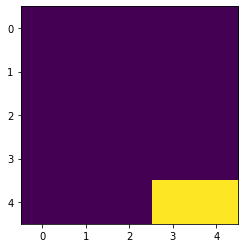

In [3]:
# Obtain the locations where the category is 2
w2 = np.where(categ==2)[0]

# Initialize the spatial signal
pi0 = 0.9  # proportion of noise (true null hypotheses)
p0 = int(np.round(pi0*m))
signal = np.zeros(m)
signal[(p0+1):m] = 1
signal = signal.reshape(Dim)

# Add the signal to the field
for I in np.arange(len(w2)):
    lat_data.field[:,:,w2[I]] = lat_data.field[:,:,w2[I]] + signal

# Convert the signal to boolean to determine whether the true signal is
bool_signal = np.zeros(Dim + (L,)) == 0
bool_signal[:,:,1] = signal > 0 

# Plot the locaion locations for illustration
plt.imshow(signal)

## Posthoc Inference

### Bootstrapping the Data

Bootstrapping is performed using the residuals of the linear model. This gives test-statistics that have the same asymptotic distribution as the limiting test-statistic (under the null). See Eck 2017 and Freedman 1981 for further details. In our context we use these to obtain bootstrapped pivotal statistics which allow us to obtain asymptotic JER control.

In [4]:
# Specify the number of bootstraps to use
B = 100

# Choose the template to use (by default the linear template is chosen)
template = 'linear'

# Run the bootstrapped algorithm
minPperm, orig_pvalues, pivotal_stats, bs = pr.boot_contrasts(lat_data, X, C, B, template, True, 1)

(50, 100)
(1, 50)


### Plotting the p-values

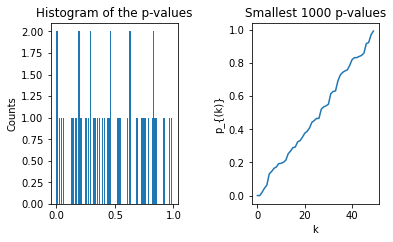

In [24]:
pval_sort_idx = np.argsort(np.ravel(orig_pvalues.field))
pvals = np.ravel(orig_pvalues.field)[pval_sort_idx]

figure, axes = plt.subplots(nrows=1, ncols=2) 
plt.subplot(121)
plt.hist(np.ravel(orig_pvalues.field), 100);
plt.title('Histogram of the p-values');
plt.ylabel('Counts');

plt.subplot(122)
plt.plot(pvals[:np.min([1000, npvals])])
plt.title('Smallest 1000 p-values')
plt.xlabel('k')
plt.ylabel('p_{(k)}')

figure.tight_layout(pad=3.0)

### Lambda Calibration

Using the bootstrapped pivotal_stats that we have calculated we can choose a value lambda that is the (alpha)% quantile (for some 0 < alpha < 1) of the distribution in order to provide asymptotic JER control at a level alpha.

In [6]:
# Choose the confidence level
alpha = 0.1

# Obtain the lambda calibration
lambda_quant = np.quantile(pivotal_stats, alpha)
print('Lambda Quantile:', lambda_quant)

# Calculate the number of voxels in the mask
m = np.sum(lat_data.mask[:])

# Gives t_k^L(lambda) = lambda*k/m for k = 1, ..., m
thr = ss.t_linear(lambda_quant, np.arange(1,m+1), m)

Lambda Quantile: 0.1799221686380359


### PostHoc Bound

For a chosen subset of voxels, provide a bound on the number of true null hypotheses within that subset. 

In [7]:
# Get the first 10 pvalues (or any subset of the p-values)
subset_pvals = np.sort(np.ravel(orig_pvalues.field))[:10]

# Compute an upper bound on the number of null hypotheses
bound = ss.max_fp(subset_pvals, thr)
print('FP Upper Bound on subset:', bound)

FP Upper Bound on subset: 10.0


### Confidence Envelopes

In [8]:
# These are the confidence envelopes. I.e. for i = 1:npvals, max_FP[i-1] is the upper bound on the number of 
# false positives that occur within the set [p[0], \dots, p[i-1]] if you were to reject all elements of that set.
max_FP = ss.curve_max_fp(subset_pvals, thr) # Confidence envelope on the chosen subset
print(max_FP)
max_FP = ss.curve_max_fp(pvals, thr) # Confidence envelope on all of them
print(max_FP[0:200])

[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]
[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 18.
 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35. 36.
 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47. 48. 49. 50.]


#### Plot the FPR and TP curve bounds

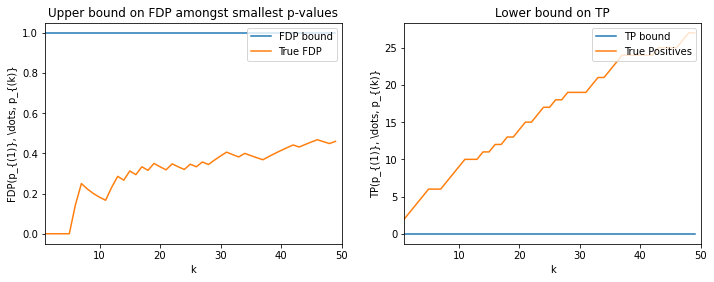

In [9]:
# Generate the vector [0,...,npvals]
one2npvals = np.arange(1, npvals+1)

# Choose the number of p-values (always the smallest ones first) to plot
lowestnumber = 1000

# Ensure that selected number is not greater than the total number of p-values
lowestnumber = np.min([lowestnumber,npvals])

# Dividing the envelope by the number of elements in the set gives a bound on the false discovery proportion
max_FDP = max_FP[0:lowestnumber]/ one2npvals[0:lowestnumber] 
min_TP = one2npvals[0:lowestnumber] - max_FP[0:lowestnumber]

# Calculate the truth (to determine if it is correctly bounded!)
sorted_signal = np.ravel(bool_signal)[pval_sort_idx]
TP = np.zeros(lowestnumber)
for I in np.arange(lowestnumber):
    TP[I] = np.sum(sorted_signal[0:I+1])
    
# Calculate the true FDP for each subset
FP = np.zeros(lowestnumber)
for I in np.arange(lowestnumber):
    FP[I] = np.sum(abs(sorted_signal[0:I+1]-1))
true_FDP = FP/one2npvals[0:lowestnumber] 
    
# Initialize the figure
figure = plt.figure(figsize=(10,4))

# Plot the false discovery proportion and its bound
plt.subplot(121)
plt.plot(max_FDP, label = 'FDP bound')
plt.plot(true_FDP, label = 'True FDP')
plt.title('Upper bound on FDP amongst smallest p-values')
plt.xlim(1, lowestnumber)
plt.xlabel('k')
plt.ylabel('FDP(p_{(1)}, \dots, p_{(k)}')
plt.legend(loc="upper right")

# Plot the true postives and their bound
plt.subplot(122)
plt.plot(min_TP, label = 'TP bound')
plt.plot(TP, label = 'True Positives')
plt.title('Lower bound on TP')
plt.legend(loc="upper right")
plt.xlim(1, lowestnumber)
plt.xlabel('k')
plt.ylabel('TP(p_{(1)}, \dots, p_{(k)}')
#figure, axes = plt.subplots(nrows=1, ncols=2) 
figure.tight_layout(pad=1.0)

As can be seen we obtain an upper bound on the false discovery proportion and a lower bound on the number of true positives with each set. Note that this bound is valid 95% of the time.

### Bootstrap paths

[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]
50


Text(0.5, 1.0, 'Plotting the ordered p-values for each bootstrap')

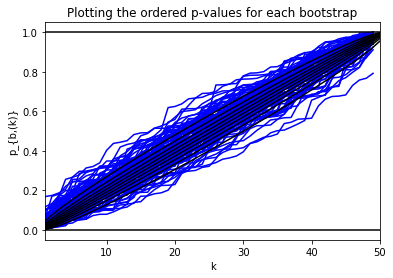

In [25]:
for b in np.arange(B):
    plt.plot(bs[:,b],color="blue")
    
# Calculate reference families
t_k, _ = pr.t_ref(template)
m = bs.shape[0]
lamb = np.arange(11)/10
print(lamb)
print(m)
k = np.arange(m+1)

for l in np.arange(len(lamb)):
    plt.plot(t_k(lamb[l],k,m),color="black")
    
plt.xlim(1, m)
plt.xlabel('k')
plt.ylabel('p_{b,(k)}')
plt.title('Plotting the ordered p-values for e  ach bootstrap')